# Trabajo Práctico N° 3

El objetivo de este trabajo práctico es implementar modelos de regresión categórica que nos permita resolver problemas de clasificación.

Para ello utilizaremos un dataset "propio", es decir, fue seleccionado por los integrantes de nuestro.

El dataset elegido fue una base de datos de estudios de Resonancia Magnética correspondiente a clientes de la empresa Canon Medical Systems Argentina.

Estos datos describen los estudios realizados por el resonador magnético indicando distintas características del mismo como:

- Fecha/Hora
- Duración
- Región Anatómica a la que corresponde
- Bobina de Radiofrecuencia Utilizada
- Tiempo de Repetición (RT)
- TIempo de Eco (TE)
- Campo de Visión (FOV)

La variable target elegida es la de **Región Anatómica**.

La lógica implentada es que según la región del cuerpo que se quiere estudiar (cabeza, tórax, muñeca, rodilla) van a variar distintos parámetros correspondientes al estudio como: tiempo de duración del mismo, tipo de bobina utilizado, campo de visión, plano de reconstrucción, tamaño de píxeles de la matriz de reconstrucción, etc.


## 0- Importación de Librerias 

In [1]:
#Importacion de librerias/módulos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
pd.set_option("display.max_columns", None)


c:\Users\VivoBook\anaconda3\envs\DH\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 1- Lectura/Análisis Inicial de los datos

### Leemos el dataset de un archivo .csv

In [2]:
#Establezco la dirección del archivo
file_location="datos_TP3.csv"

#Leo el data set usando la librería pandas
# y se almacena en el objeto Dataframe llamado datos_crudos  
datos_crudos=pd.read_csv(file_location, index_col=0)


#datos_crudos=datos_crudos.sample(30000, random_state=1)

#limito los datos a un único cliente
datos_crudos=datos_crudos.loc[datos_crudos['Site_ID']==8633]

### Visualizamos los primeros registros del mismo. Desplegando todas las columnas

In [3]:
#Configuramos para que muestre todas las columnas
pd.set_option('display.max_columns', None)

datos_crudos.sample(10)

,Study,No,Start,Scan ID,Mode,Scan Comment,Anatomy,PatientOrient,RcCoil,TxCoil,ContrastName,Plane,Sequence,Option,ScanMode,Time,TR,TE,FA,NS,ST,Gap,FOV,MTX,NAQ,BW,NoWrap,Options,Fltr,Gate,Coverages,Dynamic,SORS,FAT,MTC,Date,Site_ID,Site Name
116670,40902.838,6,07:23,MAP,(AC),iMAP_TLSpine,TL-Spine,H:S,OSP-A,WB,NaN,AX:AP,FE_map,MAP,(AC),00:31,235,4,20,29,6.0,12.4,40.0 x 52.0,64,1.0,488,RO,MAP,L1,NaN,1,OFF,NaN,OFF,OFF,2022-08-17,8633,Sanatorio Juncal
133297,42309.838,3,23:12,SG PDWI FatSAT,(A),SG PDWI FatSAT IZQ,Extremity,F:S,0x47410069,WB,NaN,Oth:Oth,FSE2D+15,NaN,(A),02:16,3669,30,90/180,20,3.8,0.8,16.0,224 x 320,1.0,122,PE,NaN,GA54,NaN,1,OFF,NaN,ON,OFF,2022-10-13,8633,Sanatorio Juncal
137178,42651.838,1,23:28,Loc 3Axis M/S(,(A),NaN,Extremity,F:S,0x47410069,WB,NaN,Oth:Oth,FE_crt,SLT,(A),00:36,44,5,25,9,6.0,1.0,18.0,128 x 256,1.0,244,PE,SLT,NL2,NaN,3,OFF,NaN,OFF,OFF,2022-10-25,8633,Sanatorio Juncal
113355,40611.838,7,02:45,MAP,(AC),iMAP_TLSpine,TL-Spine,H:S,OHD-A,WB,NaN,AX:AP,FE_map,MAP,(AC),00:31,235,4,20,29,6.0,7.8,40.0 x 50.0,64,1.0,488,RO,MAP,L1,NaN,1,OFF,NaN,OFF,OFF,2022-08-07,8633,Sanatorio Juncal
138237,42744.838,6,00:41,MAP,(A),iMAP,Shoulder,H:S,FLEXS-4C,WB,NaN,AX:AP,FE_map,MAP,(A),00:25,185,4,20,23,6.0,8.5,40.0,64,1.0,488,RO,MAP,L1,NaN,1,OFF,NaN,OFF,OFF,2022-10-29,8633,Sanatorio Juncal
133459,42321.838,17,13:10,SG T2WI,(A),SG T2WI,Chest,H:P,0x47410074,WB,NaN,SGo:COp,FSE2D+10,NaN,(A),02:36,4605,90,90/160,50,4.0,0.3,38.0 x 20.0,256,1.0,217,NaN,NaN,GA54,NaN,2,OFF,NaN,OFF,OFF,2022-10-14,8633,Sanatorio Juncal
142344,43102.838,3,17:00,AX FLAIR,(A),FLAIR,Head,H:S,OHD-A,WB,NaN,Oth:Oth,FSE2D+10,NaN,(A),03:00,10000,120,90/180,20,6.0,1.2,23.0 x 23.0,192 x 272,2.0,195,NaN,NaN,GA42,NaN,2,OFF,NaN,OFF,OFF,2022-11-10,8633,Sanatorio Juncal
140375,42928.838,17,17:20,Loc 3Axis M/S(,(AB),NaN,Abdomen,H:S,BODY,WB,NaN,Oth:Oth,FE_crt,SLT,(AB),00:15,35,4,25,9,8.0,8.0,45.0,136 x 256,1.0,244,NaN,SLT,NL1,NaN,3,OFF,NaN,OFF,OFF,2022-11-04,8633,Sanatorio Juncal
118380,41058.838,2,07:48,AX T2WI,(A),T2WI,Head,H:S,OHD-A,WB,NaN,Oth:Oth,FSE2D+15,NaN,(A),01:20,4195,105,90/160,20,6.0,1.2,23.0,224 x 448,1.0,122,NaN,NaN,GA42,NaN,1,OFF,NaN,OFF,OFF,2022-08-22,8633,Sanatorio Juncal
135987,42549.838,1,00:25,Loc 3Axis M/S(,(A),NaN,Pelvis,H:S,OSP-A,WB,NaN,Oth:AXp,FE_crt,SLT,(A),00:15,35,4,25,9,8.0,8.0,25.0,136 x 256,1.0,244,NaN,SLT,NL2,NaN,3,OFF,NaN,OFF,OFF,2022-10-22,8633,Sanatorio Juncal


## Descripción de Columnas de Interes:

- PatientOrient: Orientación del paciente dentro del gantry.
- RcCoil: Bobina de Radiofrecuencia.  
- TxCoil: Bobina de Transmisión.
- Plane: Plano del estudio.
- Sequence: Tipo de secuencia del estudio.
- Time: Tiempo de duración en minutos de la secuencia.
- TR(Repetition Time): Tiempo entre secuencias de excitación.
- TE(Echo Time): Tiempo entre excitación de campo y señal de RM.
- FA (Flip Angle): Ángulo formado por el vector spin y el plano X-Y.
- NS
- ST (Slice Thickness): Grosor axial de la imagen adquiridad.
- Gap
- FOV (Field of View): Campo de Visión, tamaño de porción anatómica que visualizaco(cm x cm)
- MTX (Matrix): Matriz de reconstrucción de la imagen (pixel x pixel). Resolución espacial.
- NAQ (Number of Adquisitions): Número de adquisiciones en una secuencia dada.


# 2- Limpieza de Datos
### Verificamos la calidad de columnas en cuanto valores nulos

In [4]:
#Ordenando de mayor a menor por porcentaje de valores nulos en cada columna
datos_crudos.isna().sum().sort_values(ascending=False)/datos_crudos.shape[0]*100

Gate             99.688999
SORS             99.685691
ContrastName     96.221671
Options          45.114971
Option           45.114971
NoWrap           44.449959
Scan Comment     18.378825
ScanMode          8.588916
Mode              8.588916
Gap               2.488007
MTX               0.000000
NAQ               0.000000
BW                0.000000
Fltr              0.000000
Study             0.000000
FOV               0.000000
Dynamic           0.000000
FAT               0.000000
MTC               0.000000
Date              0.000000
Site_ID           0.000000
Coverages         0.000000
NS                0.000000
ST                0.000000
No                0.000000
FA                0.000000
TE                0.000000
TR                0.000000
Time              0.000000
Sequence          0.000000
Plane             0.000000
TxCoil            0.000000
RcCoil            0.000000
PatientOrient     0.000000
Anatomy           0.000000
Scan ID           0.000000
Start             0.000000
S

### Realizamos limpieza de algunas columnas que podrían ser numéricas en vez de objetos

In [5]:
# Paso el campo Time con formato 00:00 a segundos
datos_crudos['Time'] = datos_crudos.Time.str.split(pat=':', expand=True)[0].astype(int)*60+\
                                datos_crudos.Time.str.split(pat=':', expand=True)[1].astype(int)

In [6]:
#Tomo el primer valor de Tiempo Eco
datos_crudos['TE'] = datos_crudos.TE.str.split(pat='/', expand=True)[0].astype(float)

In [7]:
#Primer Valor de Flip Angle
datos_crudos['FA'] = datos_crudos.FA.str.split(pat='/', expand=True)[0].astype(int)

In [8]:
#Separamos FOV en Ancho y Alto, Cuando se indica un solo valor: el FOV es cuadrado ( ancho = largo)
datos_crudos['FOV_1'] = datos_crudos.FOV.str.split(pat=' x ', expand=True)[0].astype(float)
datos_crudos['FOV_2'] = datos_crudos.FOV.str.split(pat=' x ', expand=True)[1].astype(float)

datos_crudos['FOV_2'] = datos_crudos.apply(lambda x: x['FOV_2'] if x['FOV_2'] > 0 else x['FOV_1'], axis=1)

In [9]:
#Analisis en Matriz de Reconstrucción es igual al del FOV 
datos_crudos['MTX_1'] = datos_crudos.MTX.str.split(pat=' x ', expand=True)[0].astype(int)
datos_crudos['MTX_2'] = datos_crudos.MTX.str.split(pat=' x ', expand=True)[1].astype(float)

datos_crudos['MTX_2'] = datos_crudos.apply(lambda x: x['MTX_2'] if x['MTX_2'] > 0 else x['MTX_1'], axis=1)
datos_crudos['MTX_2'] = datos_crudos['MTX_2'].astype(int)

### Removemos aquellas columnas que son redundantes y/o tiene altos valores de porcentajes nulos

In [10]:
# Drop Columnas redundantes y que tienen gran cantidad de Nans
datos=datos_crudos.drop(columns=["SORS", "Gate", "ContrastName", "Options", "Option", "NoWrap", "Site_ID", "Date","Site Name"])

### Ahora damos de la baja las filas donde haya valores nulos

In [11]:
# Drop filas con Nans restantes
datos.dropna(axis=0, inplace=True)

### Verificamos las posibles categorías de la variable target "Región Anatómica"

In [12]:
datos.Anatomy.value_counts(normalize=True)*100


Head         30.650817
Extremity    25.237321
TL-Spine     16.077995
Pelvis        9.497135
Abdomen       6.636449
C-Spine       5.144103
Shoulder      5.028650
Hand          0.949286
Chest         0.611477
Ankle         0.166766
Name: Anatomy, dtype: float64

In [13]:
# Elimino las filas con target "???""
datos = datos[datos['Anatomy'] != "???"]

## 3-Implementación de Modelos

### Definimos la matriz de features y el vector target

### No incluimos dentro la matriz de features algunas columnas que tienen una relación 1 a 1 con el vector target.

### Es el caso de las bobinas de Transmisión y de Radiofrecuencia, las mismas tienen una relación única con las partes anatómicas del cuerpo dónde son utilizadas. 

In [14]:
#Matriz de Features
X = datos[['PatientOrient','Plane','Sequence','Time','TR','TE','FA','NS','ST','Gap','FOV_1','FOV_2','MTX_1','MTX_2','NAQ']]

#Vector Target
y = datos.Anatomy

In [15]:
categorical = X.select_dtypes("object").columns
categorical

Index(['PatientOrient', 'Plane', 'Sequence'], dtype='object')

### Separamos los datos en Train y Test

In [16]:
#Train y split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [17]:
X_train

,PatientOrient,Plane,Sequence,Time,TR,TE,FA,NS,ST,Gap,FOV_1,FOV_2,MTX_1,MTX_2,NAQ
130864,H:S,Oth:Oth,SE15_opt,139,540,15.0,70,20,6.0,0.9,24.0,23.0,256,320,1.0
127838,H:S,Oth:Oth,FE_fc,232,602,13.5,35,20,3.5,0.6,17.0,17.0,192,256,1.0
126975,H:S,AX:AP,FE_map,31,235,4.0,20,29,6.0,14.7,58.5,58.5,64,64,1.0
138012,H:S,Oth:Oth,FSE2D+9,143,551,18.0,90,14,4.0,0.8,30.0,27.0,192,288,2.0
135138,H:S,AXo:AXp,FSE2D+7.5,209,3222,30.0,90,40,3.0,0.5,35.0,35.0,256,288,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122131,F:S,Oth:Oth,FSE2D+10,69,500,10.0,90,20,3.5,1.0,16.0,16.0,256,320,1.0
114554,H:S,AX:AP,FASE+6.5,44,21023,195.0,90,45,4.0,0.8,35.0,40.0,192,240,1.0
136685,H:S,AX:AP,FE_AAS,13,200,4.8,70,15,5.0,30.0,50.0,50.0,64,64,1.0
139894,H:S,AX:AP,FE_AAS,4,200,4.8,70,15,5.0,18.4,33.0,33.0,16,16,1.0


### Implementamos Dummies para las variables categóricas

In [18]:
from sklearn.preprocessing import OneHotEncoder 

def dummies_categoricas(categorias, dataframe1, dataframe2):    
        dataframe1_cat = dataframe1[categorias]
        dataframe2_cat = dataframe2[categorias]
        
        onehot = OneHotEncoder(drop = "first", handle_unknown='ignore')        
        X_enc_fit= onehot.fit_transform(dataframe1_cat).toarray()
        X_enc_trans= onehot.transform(dataframe2_cat).toarray()        
        
        enc_data_fit = pd.DataFrame(X_enc_fit, columns = onehot.get_feature_names_out())
        enc_data_trans = pd.DataFrame(X_enc_trans, columns = onehot.get_feature_names_out())
        
        dataframe1 = pd.concat([dataframe1.drop(columns=categorias).reset_index(drop=True), enc_data_fit], axis=1)
        dataframe2 = pd.concat([dataframe2.drop(columns=categorias).reset_index(drop=True), enc_data_trans], axis=1)
        
        return dataframe1, dataframe2 

In [19]:
X_train, X_test = dummies_categoricas(categorical, X_train, X_test)

c:\Users\VivoBook\anaconda3\envs\DH\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [20]:
X_train

,Time,TR,TE,FA,NS,ST,Gap,FOV_1,FOV_2,MTX_1,MTX_2,NAQ,PatientOrient_F:S,PatientOrient_H:P,PatientOrient_H:S,Plane_AX:AXp,Plane_AX:RL,Plane_AXo:AP,Plane_AXo:AXp,Plane_AXo:COp,Plane_AXo:Oth,Plane_AXo:RL,Plane_AXo:SGp,Plane_CO:COp,Plane_CO:HF,Plane_CO:RL,Plane_COo:AXp,Plane_COo:HF,Plane_COo:Oth,Plane_COo:RL,Plane_COo:SGp,Plane_Oth:AP,Plane_Oth:AXp,Plane_Oth:COp,Plane_Oth:Oth,Plane_Oth:SGp,Plane_SG:AP,Plane_SG:HF,Plane_SG:SGp,Plane_SGo:AP,Plane_SGo:AXp,Plane_SGo:COp,Plane_SGo:HF,Plane_SGo:Oth,Sequence_FASE+6.5,Sequence_FASE+8.5_nBW,Sequence_FE_AAS,Sequence_FE_dual,Sequence_FE_fc,Sequence_FE_map,Sequence_FSE2D+10,Sequence_FSE2D+11,Sequence_FSE2D+11.5,Sequence_FSE2D+12,Sequence_FSE2D+12.5,Sequence_FSE2D+14,Sequence_FSE2D+15,Sequence_FSE2D+18,Sequence_FSE2D+7.5,Sequence_FSE2D+8.5,Sequence_FSE2D+9,Sequence_SE12_opt,Sequence_SE15_opt,Sequence_SE15fc,Sequence_SE15wfop,Sequence_SE17fc,Sequence_SE_EPI100+1.0_trape,Sequence_SE_EPI80+0.8_trape,Sequence_SE_EPI90+0.8_trape,Sequence_TOF9_crt
0,139,540,15.0,70,20,6.0,0.9,24.0,23.0,256,320,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,232,602,13.5,35,20,3.5,0.6,17.0,17.0,192,256,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,31,235,4.0,20,29,6.0,14.7,58.5,58.5,64,64,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,143,551,18.0,90,14,4.0,0.8,30.0,27.0,192,288,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,209,3222,30.0,90,40,3.0,0.5,35.0,35.0,256,288,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18703,69,500,10.0,90,20,3.5,1.0,16.0,16.0,256,320,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18704,44,21023,195.0,90,45,4.0,0.8,35.0,40.0,192,240,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18705,13,200,4.8,70,15,5.0,30.0,50.0,50.0,64,64,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18706,4,200,4.8,70,15,5.0,18.4,33.0,33.0,16,16,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


###  Escalamos


In [21]:
# Scalar
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler= scaler.transform(X_test)

In [22]:
print(f"Size: {X_train_scaler.shape}")

Size: (18708, 70)


### Definimos una función que evalue los modelos aplicando distintas métricas:

In [23]:
# Funcion para Scores

resultados_fin = pd.DataFrame()

def evaluacion(y_test, y_pred, model=""):
    # Crear diccionario para almacenar los resultados
    resultados = {}

    # Calcular sensibilidad
    sensibilidad = metrics.recall_score(y_test, y_pred, average='macro')
    resultados['Sensibilidad'] = round(sensibilidad,2)

    # Calcular accuracy
    accuracy = metrics.accuracy_score(y_test, y_pred)
    resultados['Accuracy'] = round(accuracy,2)

    # Calcular precision
    precision = metrics.precision_score(y_test, y_pred, average='macro')
    resultados['Precision'] = round(precision,2)

    # Calcular F1 score
    f1_score = metrics.f1_score(y_test, y_pred, average='macro')
    resultados['F1 Score'] = round(f1_score,2)

    # Graficar matrix de confusion con heatmap
    cm = metrics.confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=np.unique(y_test).tolist(), yticklabels=np.unique(y_pred).tolist())
    plt.title(f'Matrix de Confusion {model}')
    plt.ylabel('Valor Real')
    plt.xlabel('Valor Predicho')
    plt.show()

    resultado_df = pd.DataFrame.from_dict(resultados, orient='index', columns=[model])
    resultados_fin[model]= resultado_df 
    return resultados_fin.transpose().reset_index().rename(columns={"index": "Modelos"})

## 3.1 - Regresión Logística

In [24]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=2000, random_state=1)

lr.fit(X_train_scaler, y_train) 

ypred_lr_train = lr.predict(X_train_scaler)
ypred_lr_test = lr.predict(X_test_scaler)


c:\Users\VivoBook\anaconda3\envs\DH\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


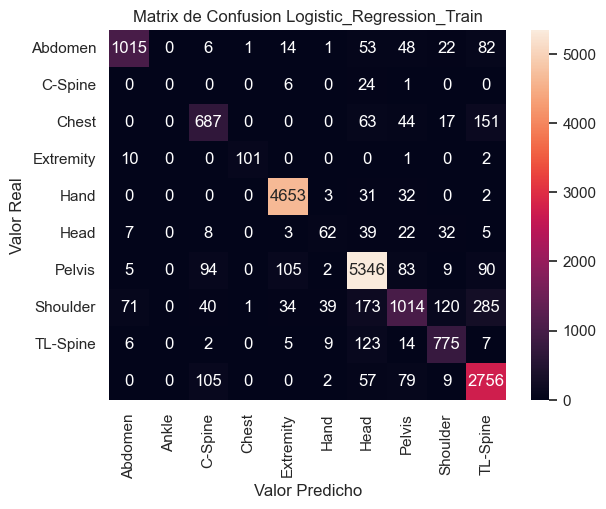

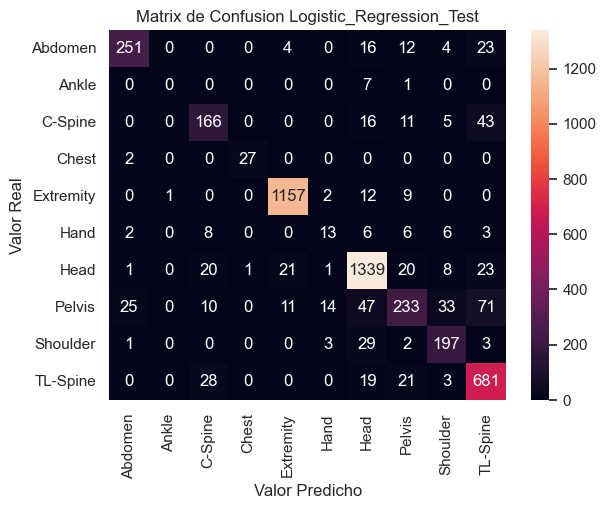

,Modelos,Sensibilidad,Accuracy,Precision,F1 Score
0,Logistic_Regression_Train,0.70,0.88,0.74,0.71
1,Logistic_Regression_Test,0.69,0.87,0.71,0.70


In [25]:
evaluacion(y_train, ypred_lr_train, model="Logistic_Regression_Train")


evaluacion(y_test, ypred_lr_test, model="Logistic_Regression_Test")


## 3.2 - Naive Bayes

In [26]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

gnb.fit(X_train_scaler, y_train)


ypred_gnb_train = gnb.predict(X_train_scaler)
ypred_gnb_test = gnb.predict(X_test_scaler)

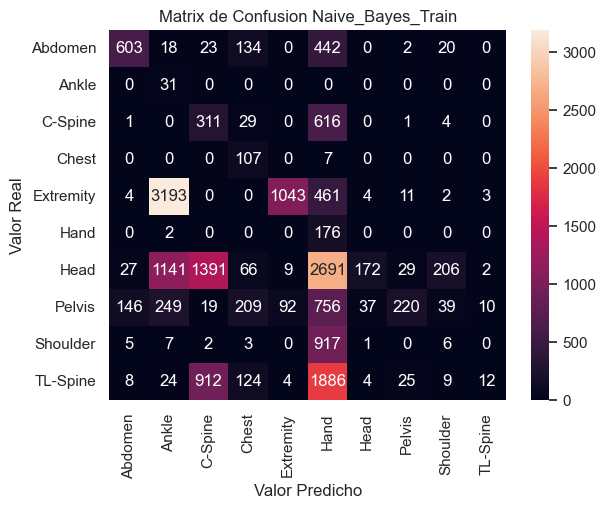

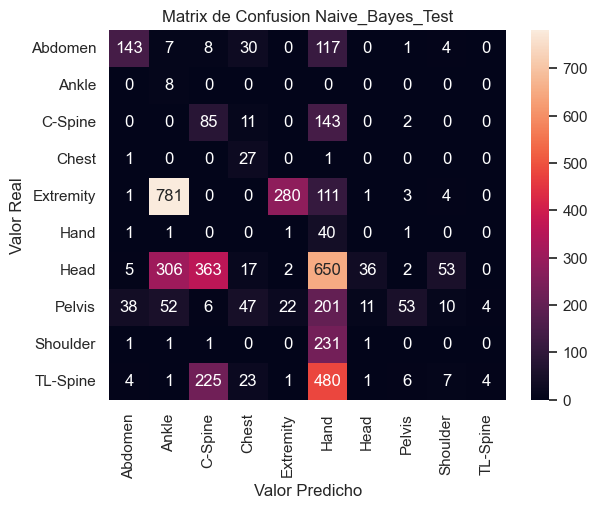

,Modelos,Sensibilidad,Accuracy,Precision,F1 Score
0,Logistic_Regression_Train,0.70,0.88,0.74,0.71
1,Logistic_Regression_Test,0.69,0.87,0.71,0.70
2,Naive_Bayes_Train,0.41,0.14,0.40,0.17
3,Naive_Bayes_Test,0.40,0.14,0.40,0.17


In [27]:

evaluacion(y_train, ypred_gnb_train, model="Naive_Bayes_Train")
evaluacion(y_test, ypred_gnb_test, model="Naive_Bayes_Test")

## 3.3 -KNN


In [28]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
parameters_knn = {"n_neighbors" : list(range(1, 15))}
clf_knn = GridSearchCV(knn, 
                   param_grid = parameters_knn, 
                   refit = True, 
                   cv = 3,
                   verbose=1,
                   n_jobs = 1)
clf_knn.fit(X_train_scaler, y_train)

Fitting 3 folds for each of 14 candidates, totalling 42 fits


GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14]},
             verbose=1)

In [29]:
print("Los mejores parametros fueron %s con un score de %0.2f" % (clf_knn.best_params_, clf_knn.best_score_))

Los mejores parametros fueron {'n_neighbors': 3} con un score de 0.93


In [30]:
ypred_knn_train = clf_knn.predict(X_train_scaler)
ypred_knn_test = clf_knn.predict(X_test_scaler)

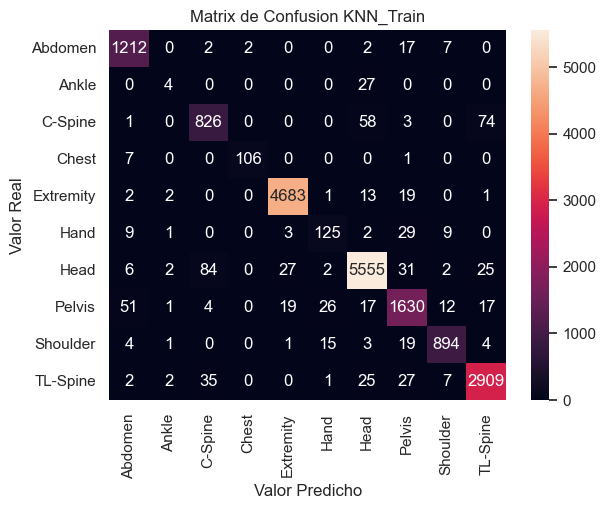

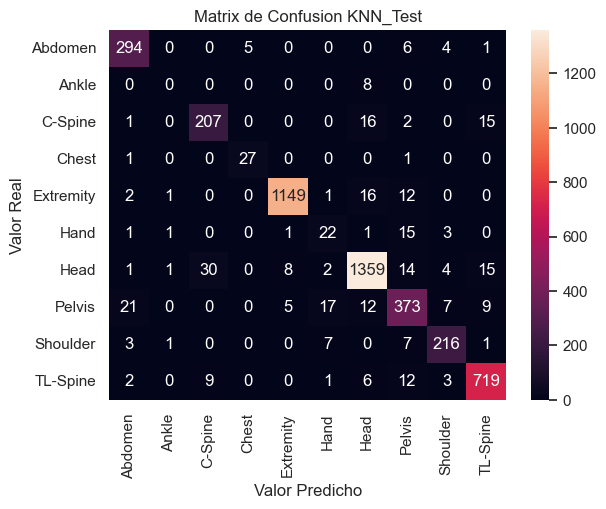

,Modelos,Sensibilidad,Accuracy,Precision,F1 Score
0,Logistic_Regression_Train,0.70,0.88,0.74,0.71
1,Logistic_Regression_Test,0.69,0.87,0.71,0.70
2,Naive_Bayes_Train,0.41,0.14,0.40,0.17
3,Naive_Bayes_Test,0.40,0.14,0.40,0.17
4,KNN_Train,0.84,0.96,0.86,0.85
5,KNN_Test,0.79,0.93,0.77,0.78


In [31]:

evaluacion(y_train, ypred_knn_train, model="KNN_Train")
evaluacion(y_test, ypred_knn_test, model="KNN_Test")

## 3.4 - Visualizacion y Comparativa de Modelos


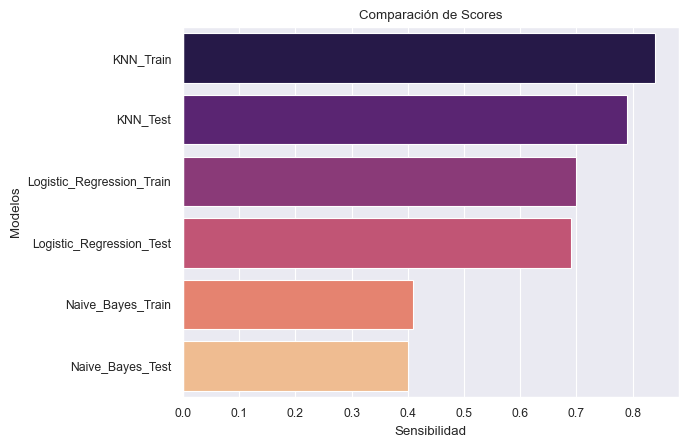

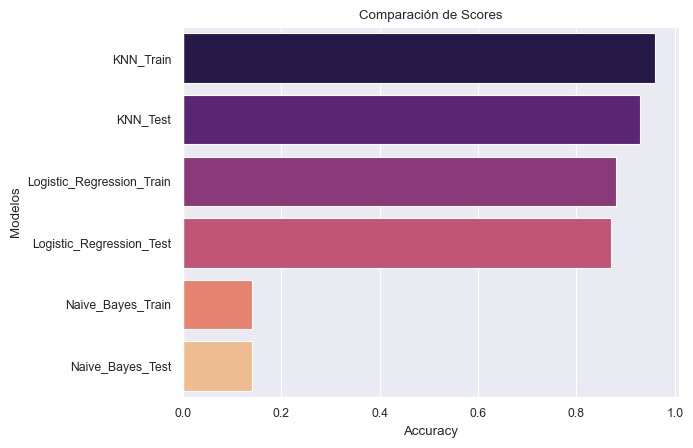

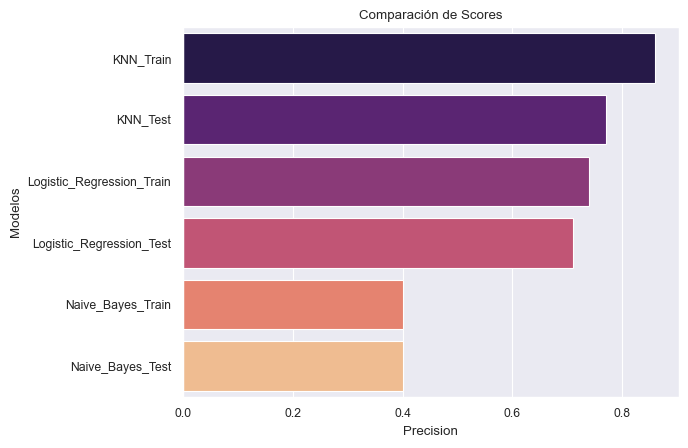

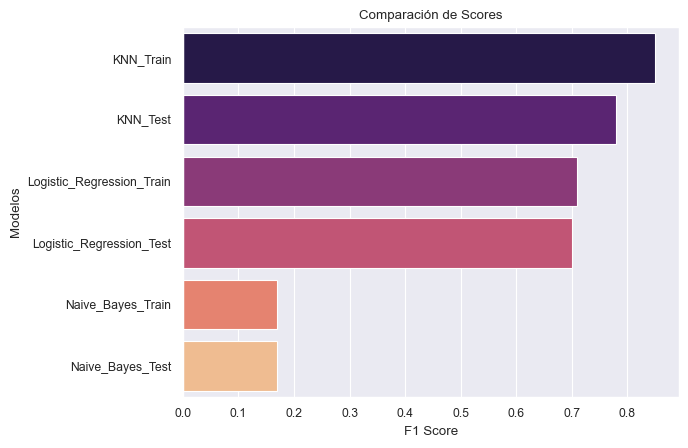

In [32]:
resultados_fin = resultados_fin.transpose().reset_index().rename(columns={"index": "Modelos"})
scores_columns= ["Sensibilidad","Accuracy", "Precision", "F1 Score"]

for scores in scores_columns:
    sns.set_context('paper')
    ax = sns.barplot(x =resultados_fin[scores] ,y = "Modelos" ,data = resultados_fin.sort_values(by=scores, ascending=False), palette = 'magma')
    ax.set(xlabel=scores, ylabel="Modelos", title="Comparación de Scores")
    plt.show()